In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


In [2]:
df = pd.read_pickle('df.plk')
df.shape

(1050, 16)

#### On souhaite associer à chaque image une catégorie cible

In [3]:
df_to_merge = df[['target','image']].copy()
df_to_merge.head()

,target,image
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


#### On créer un df avec le chemin vers les images

In [4]:
from sklearn import preprocessing

# Chemin 
path = "./Données/Flipkart/images"

# Liste d'images
list_labels = df.image.tolist()
label_no_name = "no_name "


def photo_class(photo) :
    for label in list_labels :
        if label in photo[24:] : 
            return label
    return label_no_name
    
data_path = glob(path+'*/*.jp*')

def data_fct(path) :
    list_photos = [file for file in path] # boucle sur photos
    print(len(list_photos))
    data = pd.DataFrame()
    data["image_path"] = list_photos
    data["image"] = data["image_path"].apply(lambda x : photo_class(x))
    return data

data = data_fct(data_path)

# On vérifie si les photos sont bien les mêmes
if (set(data['image'].unique()) == set(df['image'].unique())) == True:
    print('Les images des deux dataframes correspondent')

1050
Les images des deux dataframes correspondent


In [5]:
# Jointure pour récupérer la colonne target
data = df_to_merge.merge(data, on = 'image')

# Encodage pour modélisation 
le = preprocessing.LabelEncoder()
le.fit(data["target"])
data["target_encode"] = le.transform(data["target"])

# Visualisation du df
data.head()

,target,image,image_path,target_encode
0,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,./Données/Flipkart\Images\55b85ea15a1536d46b71...,4
1,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg,./Données/Flipkart\Images\7b72c92c2f6c40268628...,0
2,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg,./Données/Flipkart\Images\64d5d4a258243731dc7b...,0
3,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,./Données/Flipkart\Images\d4684dcdc759dd9cdf41...,4
4,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,./Données/Flipkart\Images\6325b6870c54cd47be6e...,4


In [6]:
target_list = data.target.unique().tolist()
target_list

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

In [7]:
# for t in target_list:
#     f(list_{t}) = t

Home Furnishing


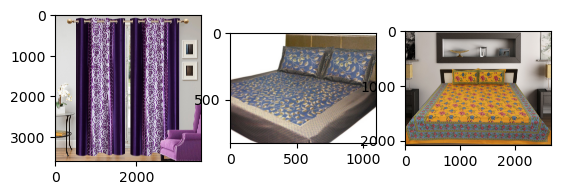

Baby Care


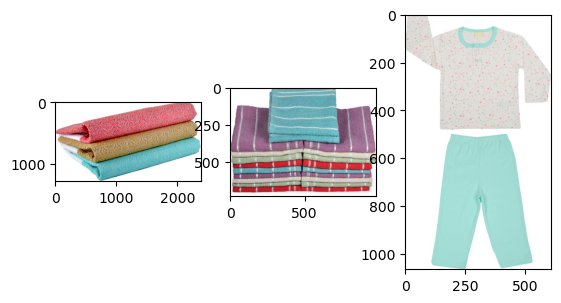

Watches


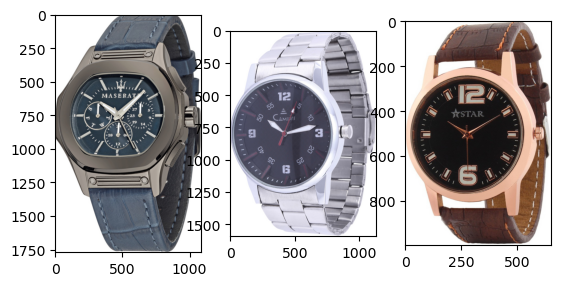

Home Decor & Festive Needs


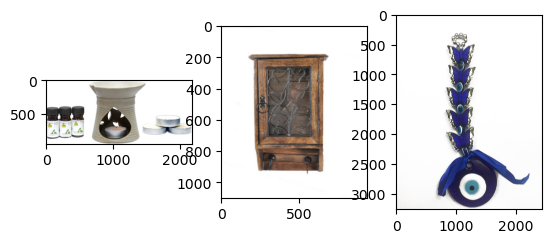

Kitchen & Dining


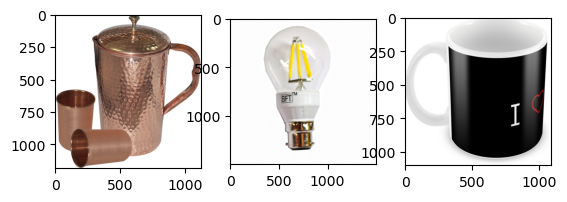

Beauty and Personal Care


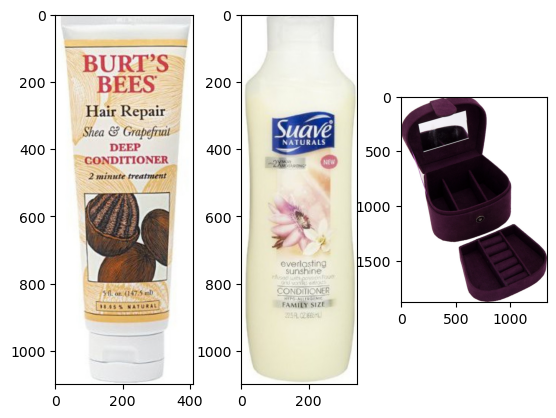

Computers


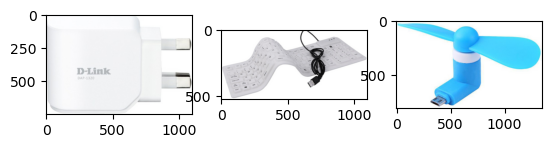

In [8]:
from matplotlib.image import imread

def list_fct(name) :
    list_image_name = [data["image_path"][i] for i in range(len(data)) if data["target"][i]==name]
    return list_image_name


list_Home_Furnishing=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Home Furnishing"]
list_Baby_Care=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Baby Care"]
list_Watches=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Watches"]
list_Home_Decor=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Home Decor & Festive Needs"]
list_Kitchen_Dining=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Kitchen & Dining"]
list_Beauty=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Beauty and Personal Care"]
list_Computers=[data["image_path"][i] for i in range(len(data)) if data["target"][i]=="Computers"]


for name in target_list :
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = list_fct(name)[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

# Etape 1 : étude de faisabilité


#### Afin d’extraire les features image, il sera nécessaire de mettre en œuvre :
2. un algorithme de type SIFT / ORB / SURF ;
3. un algorithme de type CNN Transfer Learning.

## Création du modèle pré-entraîné

In [9]:
base_model = VGG16()
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

print(model.summary())

A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 64373286793e3c8b2b4e3219cbf3544b so we will re-download the data.
553467096/553467096 [==============================] - 16s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856 

## Création des features des images

In [10]:
images_features = []
i=0 
for image_file in data["image_path"] :
    if i%100 == 0 : print(i)
    i +=1
    image = load_img(image_file, target_size=(224, 224))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    images_features.append(model.predict(image, verbose=0)[0]) # predict from pretrained model

images_features = np.asarray(images_features)
images_features.shape

0
100
200
300
400
500
600


C:\Users\Hankour\anaconda3\lib\site-packages\PIL\Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000


(1050, 4096)

## Réduction dimension et analyse

### Réduction de dimension PCA


In [11]:
from sklearn import manifold, decomposition
####
print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)
(400, 4096)
(400, 292)

(1050, 4096)
(1050, 803)


(400, 292)

### Réduction de dimension T-SNE et affichage des images selon vraies classes

In [12]:
from sklearn import manifold, decomposition
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

C:\Users\Hankour\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


temps de T-SNE :             4.62 secondes


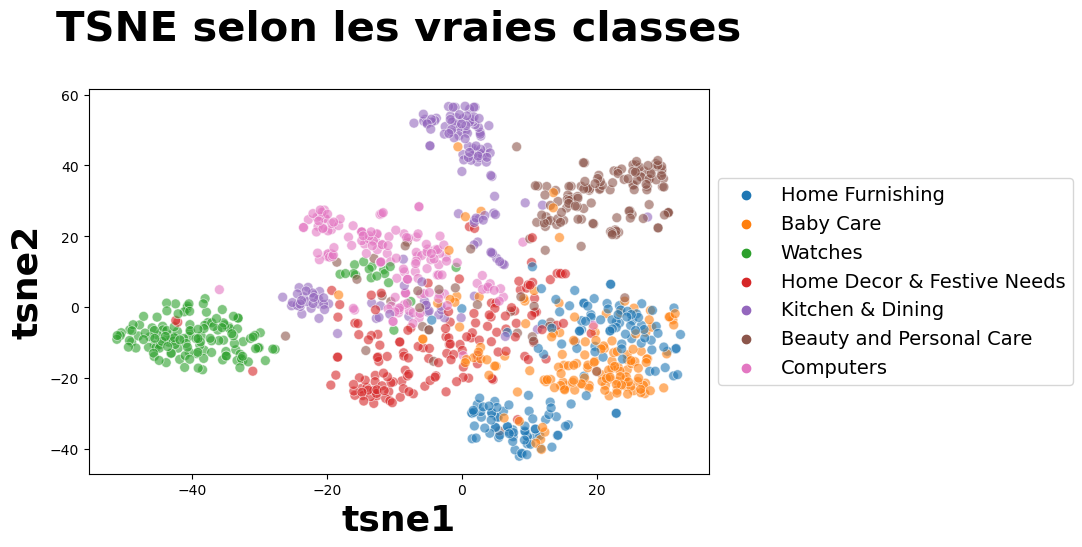

In [17]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = data["target"]

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center left', bbox_to_anchor=(1, 0.5)) 

plt.show()


### Clustering par KMeans

In [18]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(X_tsne)

KMeans(n_clusters=7, n_init=100)

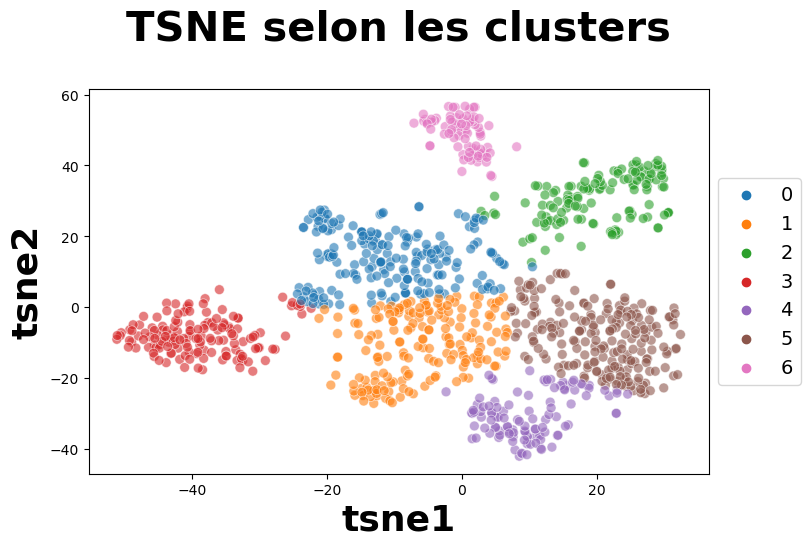

ARI :  0.4555679752185108


In [51]:
df_tsne["cluster"] = cls.labels_

plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}, loc='center left', bbox_to_anchor=(1, 0.5)) 

plt.show()

labels = data["target_encode"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

In [37]:
df_tsne.loc[
    (df_tsne['class'] == 'Home Furnishing') &
    (df_tsne['cluster'] == 4)
].index

Int64Index([   0,    3,    4,   33,   34,   67,   71,   78,  105,  109,  281,
             287,  444,  453,  611,  626,  650,  653,  659,  660,  662,  663,
             674,  676,  704,  707,  711,  713,  714,  715,  716,  718,  720,
             722,  746,  753,  758,  799,  811,  812,  813,  814,  817,  818,
             819,  821,  824,  863,  869,  926,  928,  934,  941,  942,  945,
             950,  952,  954,  959,  963,  969,  993,  999, 1017, 1020, 1022,
            1026, 1027, 1029, 1033, 1037],
           dtype='int64')

In [39]:
df_tsne.loc[
    (df_tsne['class'] == 'Baby Care') &
    (df_tsne['cluster'] == 4)
].index

Int64Index([ 110,  291,  292,  293,  449,  460,  464,  465,  599,  615,  616,
             618,  629,  630,  633,  634,  635,  636,  637,  645,  647,  904,
             967,  968,  970,  971,  979,  980, 1014, 1041, 1043, 1045],
           dtype='int64')

tsne1      24.619022
tsne2     -24.609808
class      Baby Care
cluster            4
Name: 980, dtype: object


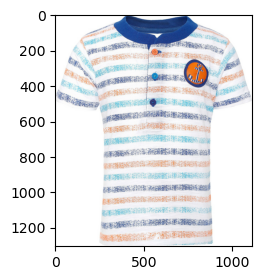

In [48]:
id = 980
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (3, 3))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()

tsne1              6.90064
tsne2           -35.149387
class      Home Furnishing
cluster                  4
Name: 34, dtype: object


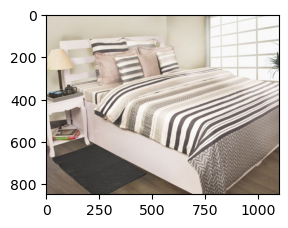

In [47]:
id = 34
print(df_tsne.iloc[id])
fig = plt.figure(figsize = (3, 3))
# plt.subplot(130 + 1 + i)
filename = data["image_path"][id]
image = imread(filename)
plt.imshow(image)
plt.show()

### Analyse par classes


In [53]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[  3  18   4   0  32  92   1]
 [ 11   7 118   1   1  11   1]
 [124  23   1   1   0   1   0]
 [  8 106   2   3   4  27   0]
 [  1   3   0   0  71  75   0]
 [ 36  20   7   8   0   1  78]
 [ 15   2   0 133   0   0   0]]


In [54]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [55]:
cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [2 3 1 6 4 0 5]
[[ 92   4   3  18  32   1   0]
 [ 11 118  11   7   1   1   1]
 [  1   1 124  23   0   0   1]
 [ 27   2   8 106   4   0   3]
 [ 75   0   1   3  71   0   0]
 [  1   7  36  20   0  78   8]
 [  0   0  15   2   0   0 133]]

              precision    recall  f1-score   support

           0       0.44      0.61      0.52       150
           1       0.89      0.79      0.84       150
           2       0.63      0.83      0.71       150
           3       0.59      0.71      0.64       150
           4       0.66      0.47      0.55       150
           5       0.97      0.52      0.68       150
           6       0.91      0.89      0.90       150

    accuracy                           0.69      1050
   macro avg       0.73      0.69      0.69      1050
weighted avg       0.73      0.69      0.69      1050



In [59]:
target_list

['Home Furnishing',
 'Baby Care',
 'Watches',
 'Home Decor & Festive Needs',
 'Kitchen & Dining',
 'Beauty and Personal Care',
 'Computers']

<AxesSubplot:>

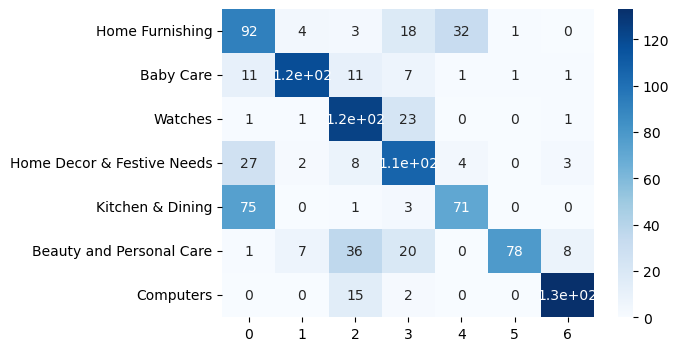

In [60]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in target_list],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")